# Lab 3: Знайомство з нейромережами

У цьому ноутбуці виконуються 3 частини завдання:
1. **Повнозв’язана нейронна мережа (FCNN)** для класифікації на даних з ЛР1 і порівняння з моделями ЛР1.  
2. **Згорткові нейронні мережі:**  
   a) проста CNN;  
   b) transfer learning з попередньо натренованою архітектурою (MobileNetV2).  
3. **Класифікація текстів (email_spam)** двома способами:  
   a) Embedding з випадковими вагами + GRU;  
   b) pretrained GloVe embeddings + GRU, порівняння метрик і швидкості/стабільності.

In [1]:

# =========================
# 0) Налаштування середовища
# =========================
import os, time, math, re, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# сумісність sklearn: sparse_output (new) vs sparse (old)
def make_ohe():
    try:
        return OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    except TypeError:
        return OneHotEncoder(handle_unknown='ignore', sparse=False)

from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# Baselines (Lab 1 models)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

# Torch (для FCNN/CNN/RNN)
try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import Dataset, DataLoader
except Exception as e:
    raise ImportError(
        "PyTorch не встановлено. Встановіть (у Jupyter cell):\n"
        "!pip install -q torch torchvision --index-url https://download.pytorch.org/whl/cpu\n"
        f"Технічна помилка імпорту: {e}"
    )

# torchvision для pretrained MobileNetV2 (частина 2b)
try:
    import torchvision
    from torchvision import models
except Exception:
    torchvision = None

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
print("Torch:", torch.__version__)
if torchvision is not None:
    print("Torchvision:", torchvision.__version__)


Device: cpu
Torch: 2.9.1+cpu
Torchvision: 0.24.1+cpu


## Допоміжні функції (метрики, тренування, візуалізація)

In [2]:

def metrics_binary(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    cm = confusion_matrix(y_true, y_pred)
    return {"accuracy": acc, "precision": p, "recall": r, "f1": f1, "cm": cm}

def plot_history(history, title="Training history"):
    plt.figure(figsize=(7,4))
    if "train_loss" in history:
        plt.plot(history["train_loss"], label="train_loss")
    if "val_loss" in history:
        plt.plot(history["val_loss"], label="val_loss")
    plt.title(title)
    plt.xlabel("epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

    if "train_acc" in history or "val_acc" in history:
        plt.figure(figsize=(7,4))
        if "train_acc" in history:
            plt.plot(history["train_acc"], label="train_acc")
        if "val_acc" in history:
            plt.plot(history["val_acc"], label="val_acc")
        plt.title(title + " (accuracy)")
        plt.xlabel("epoch")
        plt.legend()
        plt.grid(True)
        plt.show()

@torch.no_grad()
def eval_loop(model, loader, loss_fn):
    model.eval()
    losses = []
    all_logits = []
    all_y = []
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        logits = model(xb)
        loss = loss_fn(logits, yb)
        losses.append(loss.item())
        all_logits.append(logits.detach().cpu())
        all_y.append(yb.detach().cpu())
    logits = torch.cat(all_logits, dim=0).numpy()
    y_true = torch.cat(all_y, dim=0).numpy()
    y_pred = logits.argmax(axis=1)
    acc = (y_pred == y_true).mean()
    return float(np.mean(losses)), float(acc), y_true, y_pred

def train_loop(model, train_loader, val_loader, loss_fn, optimizer, epochs=20, patience=3, verbose=True):
    history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
    best_val = float("inf")
    best_state = None
    bad = 0

    for epoch in range(1, epochs+1):
        t0 = time.perf_counter()
        model.train()
        tr_losses = []
        correct = 0
        total = 0

        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad(set_to_none=True)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            loss.backward()
            optimizer.step()

            tr_losses.append(loss.item())
            pred = logits.argmax(dim=1)
            correct += (pred == yb).sum().item()
            total += yb.numel()

        train_loss = float(np.mean(tr_losses))
        train_acc = correct / max(1, total)

        val_loss, val_acc, _, _ = eval_loop(model, val_loader, loss_fn)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)

        if verbose:
            dt = time.perf_counter() - t0
            print(f"Epoch {epoch:02d}/{epochs} | "
                  f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
                  f"val_loss={val_loss:.4f} acc={val_acc:.4f} | {dt:.1f}s")

        if val_loss < best_val - 1e-4:
            best_val = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad = 0
        else:
            bad += 1
            if bad >= patience:
                if verbose:
                    print(f"Early stopping: patience={patience} досягнуто.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return history


## 1) Повнозв’язана нейронна мережа (FCNN) на датасеті з ЛР №1 (Netflix)
**Ціль:** класифікувати `type` (Movie / TV Show) на основі ознак, як у ЛР1, і порівняти з моделями з ЛР1.

In [3]:

# =========================
# 1) ДАНІ (Netflix)
# =========================
csv_path = "netflix_titles.csv.csv"
assert os.path.exists(csv_path), f"Не знайдено файл: {csv_path}"

df = pd.read_csv(csv_path)
df = df.dropna(subset=["type"]).copy()

def parse_duration(val):
    if pd.isna(val):
        return np.nan
    s = str(val).lower().strip()
    m = re.search(r"(\d+)", s)
    return float(m.group(1)) if m else np.nan

def safe_count_split(x, sep=","):
    if pd.isna(x) or not str(x).strip():
        return 0
    return len([p for p in str(x).split(sep) if p.strip()])

def parse_date_added(x):
    if pd.isna(x) or not str(x).strip():
        return (np.nan, np.nan)
    try:
        d = pd.to_datetime(x)
        return (d.year, d.month)
    except Exception:
        return (np.nan, np.nan)

df["duration_num"] = df["duration"].apply(parse_duration)
df["num_cast"] = df["cast"].apply(safe_count_split)
df["num_countries"] = df["country"].apply(safe_count_split)
df["num_genres"] = df["listed_in"].apply(safe_count_split)

year_month = df["date_added"].apply(parse_date_added)
df["year_added"] = [ym[0] for ym in year_month]
df["month_added"] = [ym[1] for ym in year_month]

feature_cols_num = ["release_year", "duration_num", "num_cast", "num_countries", "num_genres", "year_added", "month_added"]
feature_cols_cat = ["rating"]

y_raw = df["type"].astype(str).str.strip()
y = (y_raw == "TV Show").astype(int).values  # 1=TV Show, 0=Movie

X = df[feature_cols_num + feature_cols_cat].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", make_ohe()),
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, feature_cols_num),
        ("cat", categorical_transformer, feature_cols_cat),
    ],
    remainder="drop",
)

X_train_np = preprocess.fit_transform(X_train)
X_test_np = preprocess.transform(X_test)

print("X_train shape:", X_train_np.shape, " | X_test shape:", X_test_np.shape)
print("Баланс класів (train):", np.bincount(y_train), " (0=Movie, 1=TV Show)")


X_train shape: (7045, 24)  | X_test shape: (1762, 24)
Баланс класів (train): [4904 2141]  (0=Movie, 1=TV Show)


### 1.1) Базові моделі з ЛР1 (kNN, DecisionTree, SVM, RandomForest, AdaBoost)
Щоб не навантажувати CPU як GridSearchCV, тут використовуються **помірні/типові гіперпараметри** (близькі до тих, що знаходилися в ЛР1).

In [4]:

# =========================
# 1.1) БАЗОВІ МОДЕЛІ (ЛР1)
# =========================
baselines = {
    "kNN": KNeighborsClassifier(n_neighbors=9, weights="distance"),
    "DecisionTree": DecisionTreeClassifier(max_depth=None, min_samples_leaf=5, random_state=42),
    "SVM(RBF)": SVC(C=100, gamma=0.01),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42),
}

baseline_results = {}
for name, model in baselines.items():
    t0 = time.perf_counter()
    model.fit(X_train_np, y_train)
    y_pred = model.predict(X_test_np)
    m = metrics_binary(y_test, y_pred)
    dt = time.perf_counter() - t0
    baseline_results[name] = {**m, "time_sec": dt}
    print(f"{name:12s} | acc={m['accuracy']:.4f} f1={m['f1']:.4f} | time={dt:.2f}s")

baseline_results


kNN          | acc=0.9864 f1=0.9778 | time=0.12s
DecisionTree | acc=0.9989 f1=0.9981 | time=0.01s
SVM(RBF)     | acc=1.0000 f1=1.0000 | time=0.08s
RandomForest | acc=0.9989 f1=0.9981 | time=0.40s
AdaBoost     | acc=0.9983 f1=0.9972 | time=0.52s


{'kNN': {'accuracy': 0.9863791146424518,
  'precision': 0.9688073394495413,
  'recall': 0.9869158878504672,
  'f1': 0.9777777777777777,
  'cm': array([[1210,   17],
         [   7,  528]]),
  'time_sec': 0.12340698600002042},
 'DecisionTree': {'accuracy': 0.9988649262202043,
  'precision': 1.0,
  'recall': 0.9962616822429906,
  'f1': 0.99812734082397,
  'cm': array([[1227,    0],
         [   2,  533]]),
  'time_sec': 0.01028331499998103},
 'SVM(RBF)': {'accuracy': 1.0,
  'precision': 1.0,
  'recall': 1.0,
  'f1': 1.0,
  'cm': array([[1227,    0],
         [   0,  535]]),
  'time_sec': 0.0822440250000227},
 'RandomForest': {'accuracy': 0.9988649262202043,
  'precision': 1.0,
  'recall': 0.9962616822429906,
  'f1': 0.99812734082397,
  'cm': array([[1227,    0],
         [   2,  533]]),
  'time_sec': 0.39552288500004806},
 'AdaBoost': {'accuracy': 0.9982973893303064,
  'precision': 1.0,
  'recall': 0.994392523364486,
  'f1': 0.9971883786316776,
  'cm': array([[1227,    0],
         [   3

### 1.2) Повнозв’язана нейромережа (FCNN) на PyTorch

Epoch 01/25 | train_loss=0.6340 acc=0.7162 | val_loss=0.5501 acc=0.7660 | 0.3s
Epoch 02/25 | train_loss=0.4531 acc=0.8732 | val_loss=0.3374 acc=0.9447 | 0.1s
Epoch 03/25 | train_loss=0.2408 acc=0.9603 | val_loss=0.1535 acc=0.9589 | 0.1s
Epoch 04/25 | train_loss=0.1072 acc=0.9785 | val_loss=0.0772 acc=0.9702 | 0.1s
Epoch 05/25 | train_loss=0.0622 acc=0.9828 | val_loss=0.0525 acc=0.9787 | 0.1s
Epoch 06/25 | train_loss=0.0457 acc=0.9853 | val_loss=0.0435 acc=0.9816 | 0.1s
Epoch 07/25 | train_loss=0.0380 acc=0.9872 | val_loss=0.0378 acc=0.9844 | 0.2s
Epoch 08/25 | train_loss=0.0344 acc=0.9897 | val_loss=0.0338 acc=0.9872 | 0.1s
Epoch 09/25 | train_loss=0.0285 acc=0.9923 | val_loss=0.0325 acc=0.9901 | 0.1s
Epoch 10/25 | train_loss=0.0255 acc=0.9920 | val_loss=0.0305 acc=0.9901 | 0.1s
Epoch 11/25 | train_loss=0.0238 acc=0.9924 | val_loss=0.0281 acc=0.9901 | 0.1s
Epoch 12/25 | train_loss=0.0216 acc=0.9929 | val_loss=0.0276 acc=0.9915 | 0.1s
Epoch 13/25 | train_loss=0.0212 acc=0.9932 | val_los

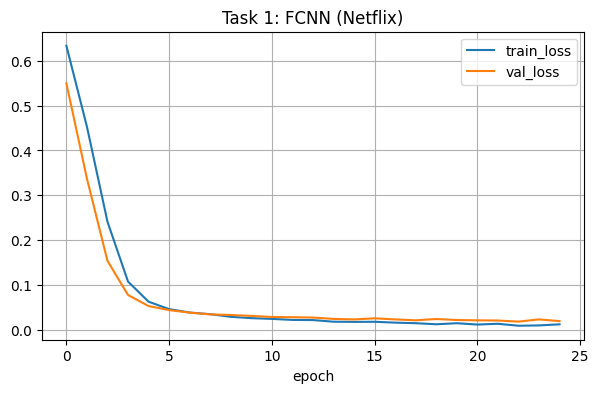

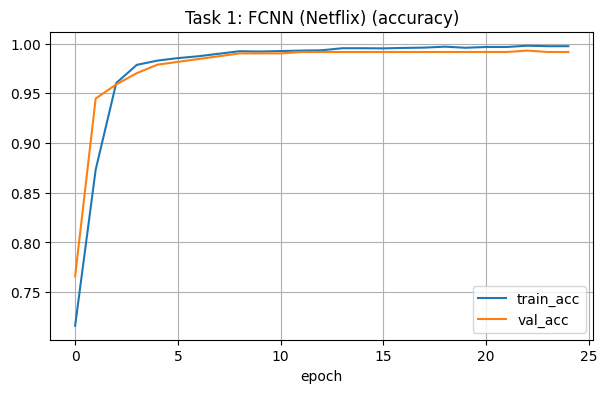


FCNN TEST: {'accuracy': 0.9994324631101021, 'precision': 0.9981343283582089, 'recall': 1.0, 'f1': 0.9990662931839402, 'cm': array([[1226,    1],
       [   0,  535]])}  | train_time=3.26s

Classification report:
              precision    recall  f1-score   support

    Movie(0)       1.00      1.00      1.00      1227
  TV Show(1)       1.00      1.00      1.00       535

    accuracy                           1.00      1762
   macro avg       1.00      1.00      1.00      1762
weighted avg       1.00      1.00      1.00      1762



({'accuracy': 0.9994324631101021,
  'precision': 0.9981343283582089,
  'recall': 1.0,
  'f1': 0.9990662931839402,
  'cm': array([[1226,    1],
         [   0,  535]])},
 3.255117874000007)

In [5]:

# =========================
# 1.2) FCNN (PyTorch)
# =========================
class TabularDataset(Dataset):
    def __init__(self, X_np, y_np):
        self.X = torch.tensor(X_np, dtype=torch.float32)
        self.y = torch.tensor(y_np, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# train/val split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_np, y_train, test_size=0.1, random_state=42, stratify=y_train
)

train_ds = TabularDataset(X_tr, y_tr)
val_ds   = TabularDataset(X_val, y_val)
test_ds  = TabularDataset(X_test_np, y_test)

train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=512, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=512, shuffle=False, num_workers=0)

class FCNN(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 2),
        )
    def forward(self, x):
        return self.net(x)

model = FCNN(in_dim=X_train_np.shape[1]).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

t0 = time.perf_counter()
history = train_loop(model, train_loader, val_loader, loss_fn, optimizer, epochs=25, patience=4, verbose=True)
train_time = time.perf_counter() - t0

plot_history(history, title="Task 1: FCNN (Netflix)")

test_loss, test_acc, y_true, y_pred = eval_loop(model, test_loader, loss_fn)
m = metrics_binary(y_true, y_pred)
print("\nFCNN TEST:", m, f" | train_time={train_time:.2f}s")

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=["Movie(0)", "TV Show(1)"], zero_division=0))

m, train_time


### 1.3) Порівняння FCNN vs моделі ЛР1

In [6]:

rows = []
for name, res in baseline_results.items():
    rows.append([name, res["accuracy"], res["f1"], res["time_sec"]])
rows.append(["FCNN (PyTorch)", m["accuracy"], m["f1"], train_time])

summary1 = pd.DataFrame(rows, columns=["model", "accuracy", "f1", "train_time_sec"])
summary1.sort_values("accuracy", ascending=False)


,model,accuracy,f1,train_time_sec
2,SVM(RBF),1.000000,1.000000,0.082244
5,FCNN (PyTorch),0.999432,0.999066,3.255118
3,RandomForest,0.998865,0.998127,0.395523
1,DecisionTree,0.998865,0.998127,0.010283
4,AdaBoost,0.998297,0.997188,0.521407
0,kNN,0.986379,0.977778,0.123407


## 2) Згорткові нейронні мережі (CNN) на `spotify-2023.csv`
Ми будуємо **CNN для табличних числових ознак** як 1D-сигнал (довжина = кількість ознак). Ціль: `in_spotify_charts > 0` (1 якщо трек був у чартах Spotify, інакше 0).

In [10]:

# =========================
# 2) ДАНІ (Spotify 2023)
# =========================
csv_path = "spotify-2023.csv"
assert os.path.exists(csv_path), f"Не знайдено файл: {csv_path}"

df_sp = pd.read_csv(csv_path, encoding="ISO-8859-1").copy()

for col in ["streams", "in_deezer_playlists", "in_shazam_charts"]:
    df_sp[col] = pd.to_numeric(df_sp[col].astype(str).str.replace(",", "", regex=False), errors="coerce")

df_sp["in_deezer_playlists"] = df_sp["in_deezer_playlists"].fillna(0)
df_sp["in_shazam_charts"]    = df_sp["in_shazam_charts"].fillna(0)
df_sp["streams"]             = df_sp["streams"].fillna(df_sp["streams"].median())

y_sp = (df_sp["in_spotify_charts"] > 0).astype(int).values

num_cols = [
    "artist_count", "released_year", "released_month", "released_day",
    "in_spotify_playlists", "in_spotify_charts", "streams",
    "in_apple_playlists", "in_apple_charts",
    "in_deezer_playlists", "in_deezer_charts",
    "in_shazam_charts",
    "bpm", "danceability_%", "valence_%", "energy_%",
    "acousticness_%", "instrumentalness_%", "liveness_%", "speechiness_%"
]
cat_cols = ["key", "mode"]

X_sp = df_sp[num_cols + cat_cols].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X_sp, y_sp, test_size=0.2, random_state=42, stratify=y_sp
)

pre_sp = ColumnTransformer(
    transformers=[
        ("num", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]), num_cols),
        ("cat", Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", make_ohe()),
        ]), cat_cols),
    ],
    remainder="drop"
)

X_train_np = pre_sp.fit_transform(X_train)
X_test_np  = pre_sp.transform(X_test)

print("Spotify processed shape:", X_train_np.shape, X_test_np.shape)
print("Class balance:", np.bincount(y_train), "(0=no charts, 1=charts)")


Spotify processed shape: (762, 33) (191, 33)
Class balance: [324 438] (0=no charts, 1=charts)


### 2a) Проста CNN (2–3 conv шари + fully connected)

n_classes = 2
Epoch 01/30 | train_loss=0.6527 acc=0.6161 | val_loss=0.5776 acc=0.6623 | 0.4s
Epoch 02/30 | train_loss=0.5844 acc=0.6978 | val_loss=0.5052 acc=0.8312 | 0.1s
Epoch 03/30 | train_loss=0.5365 acc=0.7416 | val_loss=0.4704 acc=0.8701 | 0.1s
Epoch 04/30 | train_loss=0.5072 acc=0.7489 | val_loss=0.4473 acc=0.8312 | 0.2s
Epoch 05/30 | train_loss=0.4541 acc=0.7839 | val_loss=0.4351 acc=0.8182 | 0.1s
Epoch 06/30 | train_loss=0.3640 acc=0.8409 | val_loss=0.4254 acc=0.8052 | 0.1s
Epoch 07/30 | train_loss=0.3224 acc=0.8613 | val_loss=0.4165 acc=0.8312 | 0.1s
Epoch 08/30 | train_loss=0.2649 acc=0.8847 | val_loss=0.4667 acc=0.8182 | 0.1s
Epoch 09/30 | train_loss=0.2154 acc=0.9212 | val_loss=0.4394 acc=0.8312 | 0.1s
Epoch 10/30 | train_loss=0.1805 acc=0.9358 | val_loss=0.5917 acc=0.7922 | 0.1s
Epoch 11/30 | train_loss=0.1687 acc=0.9255 | val_loss=0.4854 acc=0.8571 | 0.1s
Epoch 12/30 | train_loss=0.1900 acc=0.9197 | val_loss=0.5678 acc=0.8312 | 0.1s
Early stopping: patience=5 досягнуто.


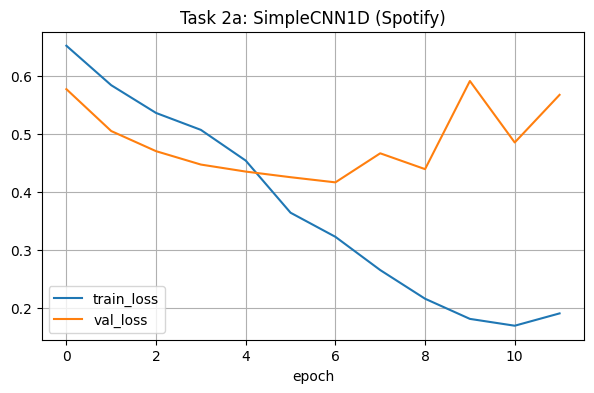

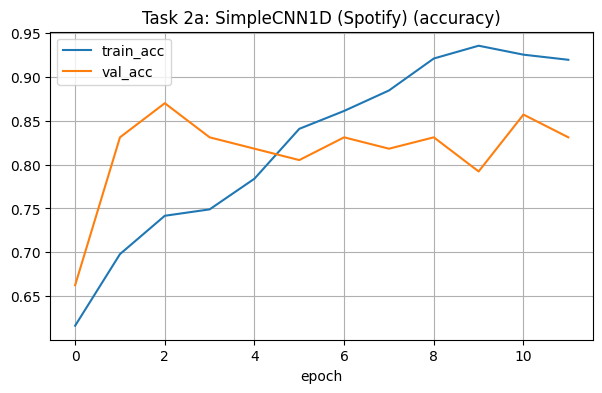


SimpleCNN1D TEST: {'accuracy': 0.8481675392670157, 'precision': 0.8785046728971962, 'recall': 0.8545454545454545, 'f1': 0.8663594470046083, 'cm': array([[68, 13],
       [16, 94]])} | train_time=1.66s


In [13]:

# =========================
# 2a) Simple CNN (Conv1D) — Spotify
# =========================
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# --- 0) Safeguards: привести все до numpy + правильні dtype ---
X_train_np = np.asarray(X_train_np, dtype=np.float32)
X_test_np  = np.asarray(X_test_np,  dtype=np.float32)

y_train_np = np.asarray(y_train, dtype=np.int64)
y_test_np  = np.asarray(y_test,  dtype=np.int64)

# --- 1) Порахувати класи ---
n_classes = int(np.unique(y_train_np).shape[0])
print("n_classes =", n_classes)

# --- 2) Train/Val split ---
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_np, y_train_np,
    test_size=0.1,
    random_state=42,
    stratify=y_train_np
)

# --- 3) Dataset ---
class SeqDataset(Dataset):
    def __init__(self, X_np, y_np):
        self.X = torch.from_numpy(np.asarray(X_np, dtype=np.float32))  # [N,F]
        self.y = torch.from_numpy(np.asarray(y_np, dtype=np.int64))    # [N]
    def __len__(self):
        return self.y.shape[0]
    def __getitem__(self, idx):
        # повертаємо [F] (model сам зробить unsqueeze якщо треба)
        return self.X[idx], self.y[idx]

train_ds = SeqDataset(X_tr,  y_tr)
val_ds   = SeqDataset(X_val, y_val)
test_ds  = SeqDataset(X_test_np, y_test_np)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True,  num_workers=0, pin_memory=False)
val_loader   = DataLoader(val_ds,   batch_size=128, shuffle=False, num_workers=0, pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=128, shuffle=False, num_workers=0, pin_memory=False)

# --- 4) Модель CNN1D з динамічним flatten ---
class SimpleCNN1D(nn.Module):
    def __init__(self, n_features: int, n_classes: int):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(32, 64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        with torch.no_grad():
            dummy = torch.zeros(1, 1, n_features)  # [B, C=1, L=n_features]
            out = self.conv(dummy)
            n_flat = out.view(1, -1).shape[1]

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_flat, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, n_classes),
        )

    def forward(self, x):
        # x: [B,F] або [B,1,F]
        if x.ndim == 2:
            x = x.unsqueeze(1)
        x = self.conv(x)
        return self.head(x)

model_cnn = SimpleCNN1D(n_features=X_train_np.shape[1], n_classes=n_classes).to(device)

# --- 5) Train ---
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)

t0 = time.perf_counter()
hist_cnn = train_loop(model_cnn, train_loader, val_loader, loss_fn, opt,
                      epochs=30, patience=5, verbose=True)
time_cnn = time.perf_counter() - t0

plot_history(hist_cnn, title="Task 2a: SimpleCNN1D (Spotify)")

# --- 6) Test ---
test_loss, test_acc, y_true, y_pred = eval_loop(model_cnn, test_loader, loss_fn)

# metrics_binary може очікувати binary; якщо у тебе багатоклас, краще окремо macro-F1
try:
    m_cnn = metrics_binary(y_true, y_pred)
    print("\nSimpleCNN1D TEST:", m_cnn, f"| train_time={time_cnn:.2f}s")
    m_cnn, time_cnn
except Exception as e:
    print("metrics_binary failed (maybe multiclass). Error:", e)
    print(f"TEST loss={test_loss:.4f}, acc={test_acc:.4f} | train_time={time_cnn:.2f}s")
    (test_loss, test_acc, time_cnn)



### 2b) Transfer learning: pretrained MobileNetV2
Тут перетворюємо табличні ознаки у маленьку «картинку» 8×8, масштабуємо до 224×224 і використовуємо **MobileNetV2**. Backbone заморожується, навчається тільки новий класифікатор.

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /home/kali/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:01<00:00, 11.7MB/s]


Epoch 01/10 | train_loss=0.6761 acc=0.6058 | val_loss=0.6654 acc=0.6104 | 22.8s
Epoch 02/10 | train_loss=0.6299 acc=0.6292 | val_loss=0.6484 acc=0.6104 | 22.1s
Epoch 03/10 | train_loss=0.6215 acc=0.6599 | val_loss=0.6009 acc=0.6234 | 22.7s
Epoch 04/10 | train_loss=0.5936 acc=0.6818 | val_loss=0.6036 acc=0.5974 | 29.0s
Epoch 05/10 | train_loss=0.5930 acc=0.6788 | val_loss=0.5821 acc=0.7013 | 28.1s
Epoch 06/10 | train_loss=0.5625 acc=0.7109 | val_loss=0.5854 acc=0.7273 | 23.3s
Epoch 07/10 | train_loss=0.5636 acc=0.7197 | val_loss=0.5709 acc=0.7013 | 23.2s
Epoch 08/10 | train_loss=0.5404 acc=0.7445 | val_loss=0.5600 acc=0.7013 | 23.8s
Epoch 09/10 | train_loss=0.5461 acc=0.6964 | val_loss=0.5673 acc=0.7013 | 23.5s
Epoch 10/10 | train_loss=0.5335 acc=0.7328 | val_loss=0.5836 acc=0.6364 | 23.3s


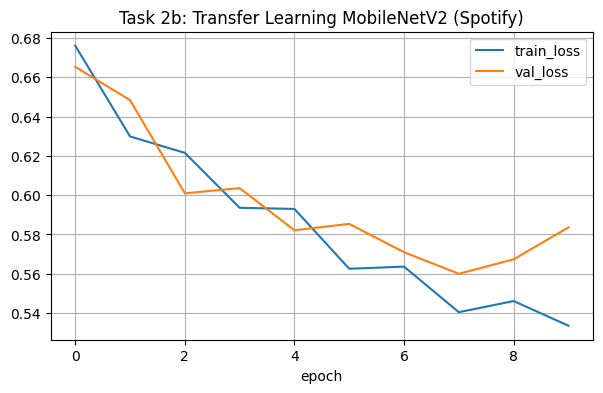

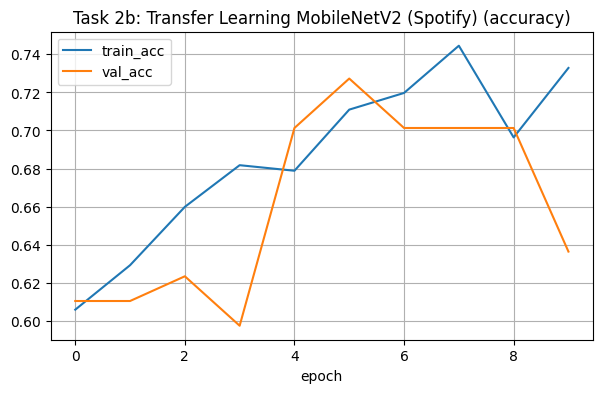


MobileNetV2 TL TEST: {'accuracy': 0.6858638743455497, 'precision': 0.6865671641791045, 'recall': 0.8363636363636363, 'f1': 0.7540983606557377, 'cm': array([[39, 42],
       [18, 92]])} | train_time=242.02s


({'accuracy': 0.6858638743455497,
  'precision': 0.6865671641791045,
  'recall': 0.8363636363636363,
  'f1': 0.7540983606557377,
  'cm': array([[39, 42],
         [18, 92]])},
 242.01760144499997)

In [14]:

# =========================
# 2b) Transfer learning (MobileNetV2)
# =========================
if torchvision is None:
    raise ImportError("torchvision не встановлено. Встановіть: !pip install -q torchvision")

import torch.nn.functional as F_torch

# Якщо інтернет повільний/відсутній, можна вимкнути pretrained:
USE_PRETRAINED = True

def features_to_image(x_feat, side=8):
    f = side * side
    if x_feat.numel() < f:
        pad = f - x_feat.numel()
        x_feat = F_torch.pad(x_feat, (0, pad))
    else:
        x_feat = x_feat[:f]
    img = x_feat.view(1, side, side)
    return img

class SpotifyImageDataset(Dataset):
    def __init__(self, X_np, y_np, side=8):
        self.X = torch.tensor(X_np, dtype=torch.float32)
        self.y = torch.tensor(y_np, dtype=torch.long)
        self.side = side
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        img1 = features_to_image(self.X[idx], side=self.side)  # [1,8,8]
        mn = img1.min()
        mx = img1.max()
        img1 = (img1 - mn) / (mx - mn + 1e-6)
        img3 = img1.repeat(3, 1, 1)  # [3,8,8]
        img3 = F_torch.interpolate(img3.unsqueeze(0), size=(224,224), mode="bilinear", align_corners=False).squeeze(0)
        return img3, self.y[idx]

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train_np, y_train, test_size=0.1, random_state=42, stratify=y_train
)

train_ds = SpotifyImageDataset(X_tr, y_tr, side=8)
val_ds   = SpotifyImageDataset(X_val, y_val, side=8)
test_ds  = SpotifyImageDataset(X_test_np, y_test, side=8)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

weights = None
if USE_PRETRAINED:
    try:
        weights = models.MobileNet_V2_Weights.DEFAULT
    except Exception:
        weights = None

try:
    base = models.mobilenet_v2(weights=weights)
except Exception as e:
    print("Не вдалося завантажити pretrained weights, використовую weights=None. Причина:", e)
    base = models.mobilenet_v2(weights=None)

for p in base.features.parameters():
    p.requires_grad = False

in_features = base.classifier[1].in_features
base.classifier[1] = nn.Linear(in_features, 2)
model_tl = base.to(device)

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_tl.classifier.parameters(), lr=1e-3)

t0 = time.perf_counter()
hist_tl = train_loop(model_tl, train_loader, val_loader, loss_fn, opt, epochs=10, patience=3, verbose=True)
time_tl = time.perf_counter() - t0

plot_history(hist_tl, title="Task 2b: Transfer Learning MobileNetV2 (Spotify)")

test_loss, test_acc, y_true, y_pred = eval_loop(model_tl, test_loader, loss_fn)
m_tl = metrics_binary(y_true, y_pred)
print("\nMobileNetV2 TL TEST:", m_tl, f"| train_time={time_tl:.2f}s")
m_tl, time_tl


### 2) Порівняння 2a vs 2b (точність, збіжність, час)

In [15]:

summary2 = pd.DataFrame([
    ["SimpleCNN1D", m_cnn["accuracy"], m_cnn["f1"], time_cnn],
    ["MobileNetV2 TL", m_tl["accuracy"], m_tl["f1"], time_tl],
], columns=["model", "accuracy", "f1", "train_time_sec"])

summary2.sort_values("accuracy", ascending=False)


,model,accuracy,f1,train_time_sec
0,SimpleCNN1D,0.848168,0.866359,1.662626
1,MobileNetV2 TL,0.685864,0.754098,242.017601


## 3) Класифікація текстів (email_spam.csv) двома способами
**Дані з ЛР2**: колонки `title`, `text`, `type` (spam / not spam).

a) Embedding (random init) + GRU
b) Pretrained GloVe + GRU

Датасет малий (84 записи), тому метрики можуть сильно «скакати». Для стабільності є validation та early stopping.

In [16]:

# =========================
# 3) ДАНІ (Email spam)
# =========================
csv_path = "email_spam.csv"
assert os.path.exists(csv_path), f"Не знайдено файл: {csv_path}"

df_em = pd.read_csv(csv_path).copy()

y = (df_em["type"].astype(str).str.strip().str.lower() == "spam").astype(int).values
texts = (df_em["title"].fillna("") + " " + df_em["text"].fillna("")).astype(str).tolist()

print("Dataset size:", len(texts), " | spam:", int(y.sum()), "not spam:", int((1-y).sum()))


Dataset size: 84  | spam: 26 not spam: 58


### 3.0) Токенізація + словник (vocab) + паддінг

In [17]:

# =========================
# 3.0) Tokenization / Vocab
# =========================
def simple_tokenize(s: str):
    s = s.lower()
    s = re.sub(r"[^a-z0-9'\s]+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s.split()

from collections import Counter

X_train, X_test, y_train, y_test = train_test_split(
    texts, y, test_size=0.3, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

max_vocab = 10000
min_freq = 1

counter = Counter()
for t in X_train:
    counter.update(simple_tokenize(t))

PAD, UNK = "<PAD>", "<UNK>"
vocab = {PAD: 0, UNK: 1}
for word, freq in counter.most_common(max_vocab):
    if freq < min_freq:
        continue
    if word not in vocab:
        vocab[word] = len(vocab)

vocab_size = len(vocab)
print("Vocab size:", vocab_size)

def encode(text: str, max_len=200):
    tokens = simple_tokenize(text)
    ids = [vocab.get(tok, vocab[UNK]) for tok in tokens][:max_len]
    if len(ids) < max_len:
        ids = ids + [vocab[PAD]] * (max_len - len(ids))
    return np.array(ids, dtype=np.int64)

max_len = 200
X_train_ids = np.stack([encode(t, max_len=max_len) for t in X_train])
X_val_ids   = np.stack([encode(t, max_len=max_len) for t in X_val])
X_test_ids  = np.stack([encode(t, max_len=max_len) for t in X_test])

print("Encoded shapes:", X_train_ids.shape, X_val_ids.shape, X_test_ids.shape)


Vocab size: 1958
Encoded shapes: (46, 200) (12, 200) (26, 200)


### 3a) Embedding (random) + GRU

Epoch 01/30 | train_loss=0.7004 acc=0.4348 | val_loss=0.6827 acc=0.6667 | 0.8s
Epoch 02/30 | train_loss=0.6704 acc=0.6957 | val_loss=0.6702 acc=0.6667 | 0.7s
Epoch 03/30 | train_loss=0.6470 acc=0.7391 | val_loss=0.6588 acc=0.6667 | 0.7s
Epoch 04/30 | train_loss=0.6341 acc=0.7391 | val_loss=0.6484 acc=0.6667 | 0.7s
Epoch 05/30 | train_loss=0.6004 acc=0.7391 | val_loss=0.6404 acc=0.6667 | 0.7s
Epoch 06/30 | train_loss=0.5952 acc=0.7391 | val_loss=0.6336 acc=0.6667 | 0.7s
Epoch 07/30 | train_loss=0.5820 acc=0.7391 | val_loss=0.6298 acc=0.6667 | 0.7s
Epoch 08/30 | train_loss=0.5669 acc=0.7391 | val_loss=0.6290 acc=0.6667 | 0.7s
Epoch 09/30 | train_loss=0.5568 acc=0.7391 | val_loss=0.6320 acc=0.6667 | 0.7s
Epoch 10/30 | train_loss=0.5578 acc=0.7391 | val_loss=0.6364 acc=0.6667 | 0.7s
Epoch 11/30 | train_loss=0.5614 acc=0.7391 | val_loss=0.6397 acc=0.6667 | 0.8s
Epoch 12/30 | train_loss=0.5516 acc=0.7391 | val_loss=0.6396 acc=0.6667 | 0.7s
Epoch 13/30 | train_loss=0.5511 acc=0.7391 | val_los

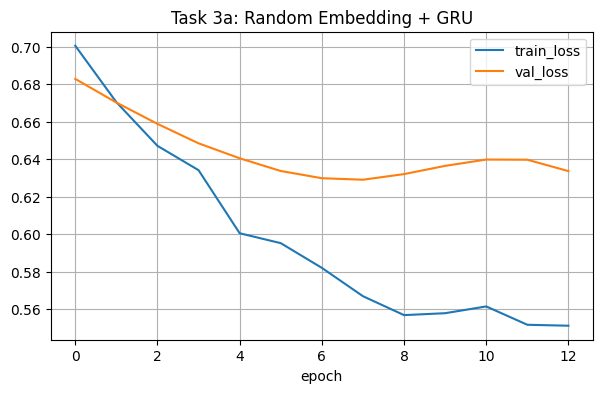

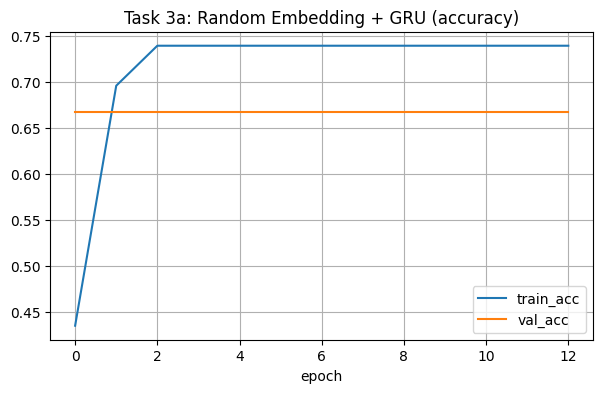


Model A TEST: {'accuracy': 0.6538461538461539, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'cm': array([[17,  1],
       [ 8,  0]])} | train_time=9.54s


({'accuracy': 0.6538461538461539,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'cm': array([[17,  1],
         [ 8,  0]])},
 9.541218034999929)

In [18]:

# =========================
# 3a) Random Embedding + GRU
# =========================
class TextDataset(Dataset):
    def __init__(self, X_ids, y_np):
        self.X = torch.tensor(X_ids, dtype=torch.long)
        self.y = torch.tensor(y_np, dtype=torch.long)
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TextDataset(X_train_ids, y_train)
val_ds   = TextDataset(X_val_ids, y_val)
test_ds  = TextDataset(X_test_ids, y_test)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=0)

class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, hidden=64, pad_idx=0, freeze_emb=False, emb_weights=None):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        if emb_weights is not None:
            self.embedding.weight.data.copy_(emb_weights)
        self.embedding.weight.requires_grad = not freeze_emb

        self.gru = nn.GRU(
            input_size=emb_dim,
            hidden_size=hidden,
            batch_first=True,
            bidirectional=True
        )
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden * 2, 2)
    def forward(self, x):
        emb = self.embedding(x)
        out, _ = self.gru(emb)
        last = out[:, -1, :]
        logits = self.fc(self.drop(last))
        return logits

model_a = GRUClassifier(vocab_size=vocab_size, emb_dim=64, hidden=64, pad_idx=vocab[PAD]).to(device)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model_a.parameters(), lr=1e-3)

t0 = time.perf_counter()
hist_a = train_loop(model_a, train_loader, val_loader, loss_fn, opt, epochs=30, patience=5, verbose=True)
time_a = time.perf_counter() - t0

plot_history(hist_a, title="Task 3a: Random Embedding + GRU")

test_loss, test_acc, y_true, y_pred = eval_loop(model_a, test_loader, loss_fn)
m_a = metrics_binary(y_true, y_pred)
print("\nModel A TEST:", m_a, f"| train_time={time_a:.2f}s")
m_a, time_a


### 3b) Pretrained embeddings (GloVe) + GRU

Завантажую GloVe zip (може бути ~60-70MB)...
Розпаковую потрібний файл: glove.6B.50d.txt
GloVe: знайдено 1821/1958 слів у словнику.
Epoch 01/30 | train_loss=0.6844 acc=0.6522 | val_loss=0.6772 acc=0.6667 | 0.9s
Epoch 02/30 | train_loss=0.6621 acc=0.7174 | val_loss=0.6677 acc=0.6667 | 0.7s
Epoch 03/30 | train_loss=0.6514 acc=0.6957 | val_loss=0.6598 acc=0.6667 | 0.7s
Epoch 04/30 | train_loss=0.6394 acc=0.6957 | val_loss=0.6530 acc=0.6667 | 0.7s
Epoch 05/30 | train_loss=0.6278 acc=0.6957 | val_loss=0.6472 acc=0.6667 | 0.7s
Epoch 06/30 | train_loss=0.6181 acc=0.6957 | val_loss=0.6425 acc=0.6667 | 0.8s
Epoch 07/30 | train_loss=0.6031 acc=0.7174 | val_loss=0.6391 acc=0.6667 | 0.8s
Epoch 08/30 | train_loss=0.6014 acc=0.6957 | val_loss=0.6376 acc=0.6667 | 0.8s
Epoch 09/30 | train_loss=0.5724 acc=0.7174 | val_loss=0.6374 acc=0.6667 | 0.8s
Epoch 10/30 | train_loss=0.5844 acc=0.7174 | val_loss=0.6392 acc=0.6667 | 0.7s
Epoch 11/30 | train_loss=0.5855 acc=0.7174 | val_loss=0.6427 acc=0.6667 | 0.9s

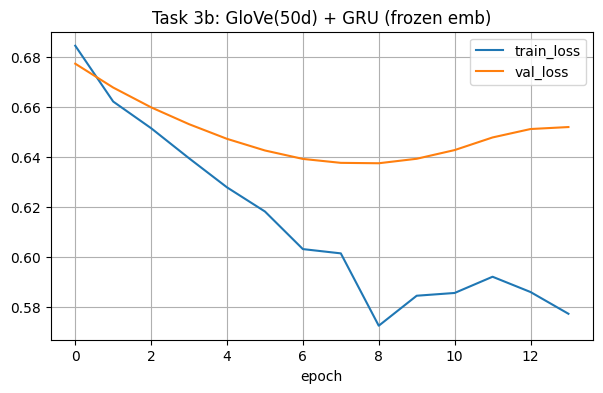

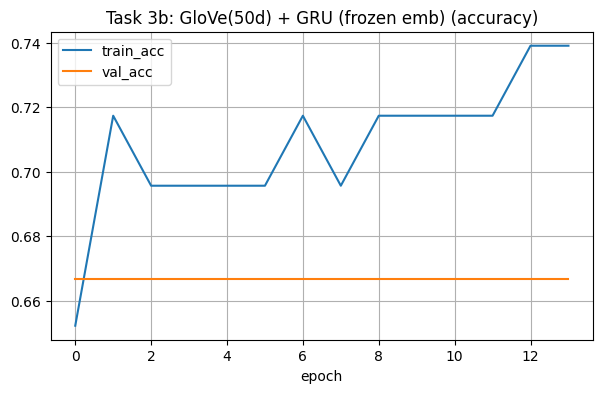


Model B TEST: {'accuracy': 0.6923076923076923, 'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'cm': array([[18,  0],
       [ 8,  0]])} | train_time=10.72s


({'accuracy': 0.6923076923076923,
  'precision': 0.0,
  'recall': 0.0,
  'f1': 0.0,
  'cm': array([[18,  0],
         [ 8,  0]])},
 10.718821073999834,
 True)

In [19]:

# =========================
# 3b) Pretrained GloVe + GRU
# =========================
import zipfile
from pathlib import Path
import urllib.request

# Якщо інтернет повільний/відсутній, можна вимкнути GloVe:
USE_GLOVE = True
DOWNLOAD_TIMEOUT_SEC = 20

GLOVE_DIM = 50
GLOVE_URL = "https://nlp.stanford.edu/data/glove.6B.zip"
glove_dir = Path("glove_cache")
glove_dir.mkdir(exist_ok=True)
zip_path = glove_dir / "glove.6B.zip"
txt_path = glove_dir / f"glove.6B.{GLOVE_DIM}d.txt"

def try_download_glove():
    if txt_path.exists():
        return True
    try:
        if not zip_path.exists():
            print("Завантажую GloVe zip (може бути ~60-70MB)...")
            with urllib.request.urlopen(GLOVE_URL, timeout=DOWNLOAD_TIMEOUT_SEC) as resp, open(zip_path, 'wb') as out:
                out.write(resp.read())
        print("Розпаковую потрібний файл:", txt_path.name)
        with zipfile.ZipFile(zip_path, "r") as z:
            z.extract(f"glove.6B.{GLOVE_DIM}d.txt", path=glove_dir)
        return txt_path.exists()
    except Exception as e:
        print("Не вдалося завантажити/розпакувати GloVe:", e)
        return False

has_glove = try_download_glove() if USE_GLOVE else False

emb_dim = GLOVE_DIM
emb_matrix = np.random.normal(0, 0.05, size=(vocab_size, emb_dim)).astype(np.float32)
emb_matrix[vocab[PAD]] = 0.0

if has_glove:
    found = 0
    with open(txt_path, "r", encoding="utf-8") as f:
        for line in f:
            parts = line.rstrip().split(" ")
            word = parts[0]
            if word in vocab:
                vec = np.asarray(parts[1:], dtype=np.float32)
                if vec.shape[0] == emb_dim:
                    emb_matrix[vocab[word]] = vec
                    found += 1
    print(f"GloVe: знайдено {found}/{vocab_size} слів у словнику.")
else:
    print("GloVe недоступний -> продовжую з випадковими embedding (це вплине на порівняння).")

emb_weights = torch.tensor(emb_matrix, dtype=torch.float32)

model_b = GRUClassifier(
    vocab_size=vocab_size,
    emb_dim=emb_dim,
    hidden=64,
    pad_idx=vocab[PAD],
    freeze_emb=True,
    emb_weights=emb_weights
).to(device)

loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam([p for p in model_b.parameters() if p.requires_grad], lr=1e-3)

t0 = time.perf_counter()
hist_b = train_loop(model_b, train_loader, val_loader, loss_fn, opt, epochs=30, patience=5, verbose=True)
time_b = time.perf_counter() - t0

plot_history(hist_b, title="Task 3b: GloVe(50d) + GRU (frozen emb)")

test_loss, test_acc, y_true, y_pred = eval_loop(model_b, test_loader, loss_fn)
m_b = metrics_binary(y_true, y_pred)
print("\nModel B TEST:", m_b, f"| train_time={time_b:.2f}s")
m_b, time_b, has_glove


### 3) Порівняння (a) vs (b)

In [20]:

summary3 = pd.DataFrame([
    ["A: Random Embedding + GRU", m_a["accuracy"], m_a["f1"], time_a],
    ["B: GloVe(50d) + GRU",      m_b["accuracy"], m_b["f1"], time_b],
], columns=["model", "accuracy", "f1", "train_time_sec"])

summary3.sort_values("accuracy", ascending=False)


,model,accuracy,f1,train_time_sec
1,B: GloVe(50d) + GRU,0.692308,0.0,10.718821
0,A: Random Embedding + GRU,0.653846,0.0,9.541218


## Висновки


In [21]:

print("=== Summary 1 (Lab1 vs FCNN) ===")
display(summary1)
print("\n=== Summary 2 (CNN vs Transfer Learning) ===")
display(summary2)
print("\n=== Summary 3 (Text: random vs GloVe) ===")
display(summary3)


=== Summary 1 (Lab1 vs FCNN) ===


,model,accuracy,f1,train_time_sec
0,kNN,0.986379,0.977778,0.123407
1,DecisionTree,0.998865,0.998127,0.010283
2,SVM(RBF),1.000000,1.000000,0.082244
3,RandomForest,0.998865,0.998127,0.395523
4,AdaBoost,0.998297,0.997188,0.521407
5,FCNN (PyTorch),0.999432,0.999066,3.255118



=== Summary 2 (CNN vs Transfer Learning) ===


,model,accuracy,f1,train_time_sec
0,SimpleCNN1D,0.848168,0.866359,1.662626
1,MobileNetV2 TL,0.685864,0.754098,242.017601



=== Summary 3 (Text: random vs GloVe) ===


,model,accuracy,f1,train_time_sec
0,A: Random Embedding + GRU,0.653846,0.0,9.541218
1,B: GloVe(50d) + GRU,0.692308,0.0,10.718821
